In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from keras import metrics
import random
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import cv2
import PIL
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tqdm import tqdm
from keras import backend as K

In [2]:
# load crop data pairs

# Paths to your data.
pos_path = './archive/cropped/CFD_background_region/'
neg_path = './archive/cropped/CFD_background_region/'
img_size = (112, 112)

# Load and preprocess data
def load_data_pairs(pos_path, neg_path):
    pos_images= []  # List to store the images
    neg_images = []   # List to store the masks
    pairList = []
    files = []
    count = 0
    for filename in os.listdir(pos_path):
        if count > 320:
            break
        pos_img_path = pos_path + filename
        neg_img_path = neg_path + filename  # Assuming mask has same filename
        # print(img_path)
        # Load and preprocess the image
        pos_img = cv2.imread(pos_img_path)
        neg_img = cv2.imread(neg_img_path)
        # print(img.size())
    #   if not img or not mask:
    #         continue
        pos_img = cv2.resize(pos_img , (112, 112)) 
        neg_img = cv2.resize(pos_img , (112, 112)) 
        pos_img, neg_img = pos_img/255.0,  neg_img/255.0
        # img = cv2.resize(img, img_size) / 255.0
        # # Load and preprocess the mask using OpenCV
        # mask = cv2.resize(mask, img_size) / 255.0
 
        # for i in range(4):
        #     for j in range(4):
        #         img_part = pos_img[i * 112: (i + 1) * 112,
        #                     j * 112: (j + 1) * 112]
        #         mask_part = neg_img[i * 112: (i + 1) * 112,
        #                     j * 112: (j + 1) * 112]
        pos_images.append(pos_img)
        neg_images.append(neg_img)
        files.append(filename)
         
        count += 1
 
    return np.array(pos_images), np.array(neg_images)
 

pos_img, neg_img = load_data_pairs(pos_path, neg_path)
pos_ds = tf.data.Dataset.from_tensor_slices(pos_img)
neg_ds = tf.data.Dataset.from_tensor_slices(neg_img)

# Zip the positive and negative datasets together to create pairs
train_dataset = tf.data.Dataset.zip((pos_ds, neg_ds))

# Shuffle and batch the dataset as needed
buffer_size = len(pos_img)  # This should be the number of images, can be replaced with a suitable buffer size
batch_size = 2  # Define your batch size as needed
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)

# Prefetch data for performance optimization
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
 

improved unet

In [3]:
def residual_block(input_tensor, num_filters):
    # Check if a projection shortcut is needed
    input_shape = input_tensor.shape[-1]
    if input_shape != num_filters:
        shortcut = layers.Conv2D(num_filters, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    else:
        shortcut = input_tensor

    x = layers.Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Add the shortcut (which has been adjusted if necessary) to the output of the convolution block
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x
# Attention gate
def attention_gate(input_tensor, gate_tensor, num_filters):
    # Resize gate tensor to match the input_tensor shape using a 1x1 convolution
    gate_resized = layers.Conv2D(num_filters, 1, padding='same')(gate_tensor)
    gate_resized = layers.BatchNormalization()(gate_resized)
    gate_resized = layers.ReLU()(gate_resized)

    # Add the gate to the input_tensor
    x = layers.add([input_tensor, gate_resized])
    attention = layers.Conv2D(num_filters, 1, padding='same', activation='sigmoid')(x)
    x = layers.multiply([input_tensor, attention])

    return x

def conv_block(input_tensor, num_filters):
    x = residual_block(input_tensor, num_filters)
    return x

def encoder_block(input_tensor, num_filters, block_name):
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', name=f"{block_name}_conv")(input_tensor)
    x = layers.BatchNormalization(name=f"{block_name}_bn")(x)
    p = layers.MaxPooling2D((2, 2), name=f"{block_name}_pool")(x)
    return x, p

# Modify the decoder_block to include an attention gate
def decoder_block(input_tensor, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)

    # Apply attention gate to the skip features before concatenating
    attention_skipped = attention_gate(skip_features, x, num_filters)

    # Concatenate upsampled input with the attention modified skip features
    x = layers.concatenate([x, attention_skipped])
    x = conv_block(x, num_filters)
    return x


encoder

In [4]:
# def build_encoder(input_shape):
#     inputs = layers.Input(shape=input_shape)
#     x, _ = encoder_block(inputs, 64)
#     x, _ = encoder_block(x, 128)
#     x, _ = encoder_block(x, 256)
#     x, _ = encoder_block(x, 512)
#     x = conv_block(x, 1024)
#     x = layers.GlobalAveragePooling2D()(x)
#     return keras.Model(inputs, x, name="encoder")
def build_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    s1, p1 = encoder_block(inputs, 64, "pre1")
    s2, p2 = encoder_block(p1, 128, "pre2")
    s3, p3 = encoder_block(p2, 256, "pre3")
    s4, p4 = encoder_block(p3, 512, "pre4")
 
    x = layers.GlobalAveragePooling2D()(p4)
    return keras.Model(inputs, x, name="encoder")

# Define the projection head using the functional API
def build_projection_head(encoder):
    inputs = layers.Input(shape=(512,))
    x = layers.Dense(512, activation="relu")(inputs)
    outputs = layers.Dense(256)(x)
    return keras.Model(inputs, outputs, name="projection_head")

# Get the models
input_shape = (112, 112, 3)
encoder_model = build_encoder(input_shape)
projection_head_model = build_projection_head(encoder_model)

contrastive_loss

In [5]:
import tensorflow as tf

# Cosine similarity function
def cosine_similarity(z1, z2):
    z1 = tf.math.l2_normalize(z1, axis=1)
    z2 = tf.math.l2_normalize(z2, axis=1)
    return tf.matmul(z1, z2, transpose_b=True)

def contrastive_loss(z_crack, z_bg, other_proj, temperature=0.5):
    # Normalize the input projections
    z_crack_norm = tf.math.l2_normalize(z_crack, axis=1)
    z_bg_norm = tf.math.l2_normalize(z_bg, axis=1)
    other_proj_norm = tf.math.l2_normalize(other_proj, axis=1)
 
    # Compute the positive similarity scores
    pos_sim = tf.reduce_sum(z_crack_norm * z_bg_norm, axis=1, keepdims=True)
    exp_pos_sim = tf.exp(pos_sim / temperature)

    # Compute the negative similarity scores
    neg_sim_z_crack = tf.matmul(z_crack_norm, other_proj_norm, transpose_b=True)
    neg_sim_z_bg = tf.matmul(z_bg_norm, other_proj_norm, transpose_b=True)

    # Sum the exponentials of the negative similarities
    sum_exp_neg_sim_z_crack = tf.reduce_sum(tf.exp(neg_sim_z_crack / temperature), axis=1, keepdims=True)
    sum_exp_neg_sim_z_bg = tf.reduce_sum(tf.exp(neg_sim_z_bg / temperature), axis=1, keepdims=True)

    # Calculate the loss for the positive pair with respect to all other projections
    loss_z_crack = -tf.math.log(exp_pos_sim / (sum_exp_neg_sim_z_crack + exp_pos_sim + 1e-9)) # Add epsilon for numerical stability
    loss_z_bg = -tf.math.log(exp_pos_sim / (sum_exp_neg_sim_z_bg + exp_pos_sim + 1e-9))

    # Combine the losses for both members of the positive pair
    loss_per_pair = loss_z_crack + loss_z_bg

    # Average the loss across all positive pairs
    loss = tf.reduce_mean(loss_per_pair)

    return loss


In [6]:

inputs = tf.keras.Input(shape=(112, 112, 3))

# Forward pass through the encoder and projection head
encoder = build_encoder(input_shape=(112, 112, 3))
encoder_output_shape = encoder.output_shape[1]
projection_head = build_projection_head(encoder_output_shape)

encoded = encoder(inputs)
projected = projection_head(encoded)

# Define the Keras model
model = tf.keras.Model(inputs=inputs, outputs=projected)

# Compile the model with a dummy optimizer and loss since we are using a custom training loop
model.compile(optimizer='adam', loss=None)
num_epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    pbar = tqdm(total=len(train_dataset), desc='Training', leave=True)
    
    for step, (images_crack, images_bg) in enumerate(train_dataset):
        # Open the GradientTape context to capture gradients
        with tf.GradientTape() as tape: 
            # Compute all projections first
            proj_crack = model(images_crack, training=True)  # Projections of crack images
            proj_bg = model(images_bg, training=True)  # Projections of background images
            all_projections = tf.concat([proj_crack, proj_bg], axis=0)

            # Calculate the loss for each image
            loss_values = []
            for i in range(tf.shape(proj_crack)[0]):
                # Positive pair for the current sample
                pos_pair = tf.concat([proj_crack[i:i+1], proj_bg[i:i+1]], axis=0)
                other_bg = tf.concat([proj_bg[0:i], proj_bg[i+1:]], axis=0)
                other_crack = tf.concat([proj_crack[0:i], proj_crack[i+1:]], axis=0)
                other_pj = tf.concat([other_bg[:], other_crack[:]], axis = 0)
                # Compute the loss for the current pair against all other projections
                loss_value = contrastive_loss(pos_pair[0:1], pos_pair[1:2], other_pj, temperature=0.5)
                loss_values.append(loss_value)

            # Calculate the mean of the loss values for gradient update
            batch_loss = tf.reduce_mean(tf.stack(loss_values))

        # Calculate gradients and update model weights
        gradients = tape.gradient(batch_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        pbar.update(1)
        pbar.set_postfix(loss=f"{batch_loss.numpy():.4f}")

    pbar.close()


Epoch 1/10


Training: 100%|██████████| 59/59 [00:21<00:00,  2.80it/s, loss=-0.0000]


Epoch 2/10


Training: 100%|██████████| 59/59 [00:20<00:00,  2.83it/s, loss=-0.0000]


Epoch 3/10


Training: 100%|██████████| 59/59 [00:20<00:00,  2.86it/s, loss=-0.0000]


Epoch 4/10


Training: 100%|██████████| 59/59 [00:20<00:00,  2.88it/s, loss=-0.0000]


Epoch 5/10


Training: 100%|██████████| 59/59 [00:20<00:00,  2.85it/s, loss=-0.0000]


Epoch 6/10


Training: 100%|██████████| 59/59 [00:20<00:00,  2.90it/s, loss=-0.0000]


Epoch 7/10


Training: 100%|██████████| 59/59 [00:20<00:00,  2.87it/s, loss=-0.0000]


Epoch 8/10


Training: 100%|██████████| 59/59 [00:20<00:00,  2.88it/s, loss=-0.0000]


Epoch 9/10


Training: 100%|██████████| 59/59 [00:20<00:00,  2.90it/s, loss=-0.0000]


Epoch 10/10


Training: 100%|██████████| 59/59 [00:20<00:00,  2.88it/s, loss=-0.0000]


In [7]:
# encoder_layers = [layer for layer in encoder_model.layers if 'conv' in layer.name or 'pooling' in layer.name]
# model_encoder_layers = [layer for layer in model.layers if 'conv' in layer.name or 'pooling' in layer.name][:len(encoder_layers)]
# for unet_layer, encoder_layer in zip(model_encoder_layers, encoder_layers):
#     unet_layer.set_weights(encoder_layer.get_weights())

In [8]:
def decoder_block(input_tensor, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    attention_skipped = attention_gate(skip_features, x, num_filters)  # Apply attention gate
    x = layers.concatenate([x, attention_skipped])
    x = conv_block(x, num_filters)
    return x

# Function to build the entire U-Net model
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64, "encoder1")
    s2, p2 = encoder_block(p1, 128, "encoder2")
    s3, p3 = encoder_block(p2, 256, "encoder3")
    s4, p4 = encoder_block(p3, 512, "encoder4")


    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(d4)
 
    model = models.Model(inputs, outputs)
    return model

# if TF:
#     from tensorflow.keras import backend as K
# else:

#     from keras import backend as K

# Build the U-Net model
input_shape = (112, 112, 3)
unet_model = build_unet(input_shape)
for layer in unet_model.layers:
    if 'enoder' in layer.name:  # Only load weights for the encoder layers
        layer_name = "pre" + layer.name[-1]  # Assumes layer names are like "block1_conv"
        layer_weights = encoder.get_layer(layer_name).get_weights()
        layer.set_weights(layer_weights)

# Compile the U-Net model
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + 1) / (denominator + 1)

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    sum_ = tf.reduce_sum(tf.abs(y_true) + tf.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

unet_model.compile(optimizer='adam',
                   loss= jaccard_distance,
                   metrics=[metrics.Precision(),
                            metrics.Recall(),
                            metrics.FalsePositives(),
                            metrics.FalseNegatives(),
                            metrics.BinaryIoU()])

# 

In [9]:

# Paths to your data.
images_path = './archive/crack_segmentation_dataset/train/images/'
masks_path = './archive/crack_segmentation_dataset/train/masks/'
img_size = (112, 112)

# Load and preprocess data
def load_data(images_path, masks_path, img_size):
    images = []  # List to store the images
    masks = []   # List to store the masks
    path = ''
    files = []
    count = 0
    for filename in os.listdir(images_path):
        if count > 500:
            break
        img_path = images_path + filename
        mask_path = masks_path + filename  # Assuming mask has same filename
        # print(img_path)
        # Load and preprocess the image
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # print(img.size())
    #   if not img or not mask:
    #         continue
        # img, mask = img/255.0, mask/255.0
        img = cv2.resize(img, img_size) / 255.0
        # Load and preprocess the mask using OpenCV
        mask = cv2.resize(mask, img_size) / 255.0
 
        # for i in range(4):
        #     for j in range(4):
        #         img_part = img[i * 112: (i + 1) * 112,
        #                     j * 112: (j + 1) * 112]
        #         mask_part = mask[i * 112: (i + 1) * 112,
        #                     j * 112: (j + 1) * 112]
        #         images.append(img_part)
        #         masks.append(mask_part)
        images.append(img)
        masks.append(mask)
        files.append(filename)
         
        count += 1
    print(files)
    return np.array(images), np.array(masks)


In [10]:
def load_test(images_path, masks_path, img_size):
    images = []  # List to store the images
    masks = []   # List to store the masks
    path = ''
    count = 0
    print()
    imgList = os.listdir(images_path)
    files = []
    for i in range(len(imgList) - 1, -1, -1):
        filename = imgList[i]
    # for filename in os.listdir(images_path):
        if count >= 100:
            break

        img_path = images_path + filename
        mask_path = masks_path + filename  # Assuming mask has same filename

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, img_size) / 255.0
        # Load and preprocess the mask using OpenCV
        mask = cv2.resize(mask, img_size) / 255.0
 
  
        # img, mask = img/255.0, mask/255.0
        # while 1:
        #     i, j = random.randint(0, 3), random.randint(0, 3)
        #     img_part = img[i * 112: (i + 1) * 112,
        #                 j * 112: (j + 1) * 112]
        #     mask_part = mask[i * 112: (i + 1) * 112,
        #                 j * 112: (j + 1) * 112]
        #     if np.sum(mask_part) > 0:
        #         break
        # images.append(img_part)
        # masks.append(mask_part)

        images.append(img)
        masks.append(mask)


        files.append(filename)
        count += 1
    print(files)
    return np.array(images), np.array(masks)

In [11]:
# Load your data

images, masks = load_data(images_path, masks_path, (112, 112))


['CFD_002.jpg', 'CFD_003.jpg', 'CFD_004.jpg', 'CFD_005.jpg', 'CFD_006.jpg', 'CFD_008.jpg', 'CFD_009.jpg', 'CFD_010.jpg', 'CFD_012.jpg', 'CFD_015.jpg', 'CFD_016.jpg', 'CFD_017.jpg', 'CFD_018.jpg', 'CFD_020.jpg', 'CFD_021.jpg', 'CFD_022.jpg', 'CFD_023.jpg', 'CFD_024.jpg', 'CFD_025.jpg', 'CFD_026.jpg', 'CFD_027.jpg', 'CFD_028.jpg', 'CFD_029.jpg', 'CFD_030.jpg', 'CFD_031.jpg', 'CFD_032.jpg', 'CFD_033.jpg', 'CFD_034.jpg', 'CFD_035.jpg', 'CFD_036.jpg', 'CFD_038.jpg', 'CFD_039.jpg', 'CFD_041.jpg', 'CFD_042.jpg', 'CFD_043.jpg', 'CFD_044.jpg', 'CFD_045.jpg', 'CFD_046.jpg', 'CFD_048.jpg', 'CFD_049.jpg', 'CFD_050.jpg', 'CFD_051.jpg', 'CFD_052.jpg', 'CFD_053.jpg', 'CFD_054.jpg', 'CFD_055.jpg', 'CFD_056.jpg', 'CFD_057.jpg', 'CFD_058.jpg', 'CFD_059.jpg', 'CFD_060.jpg', 'CFD_061.jpg', 'CFD_062.jpg', 'CFD_063.jpg', 'CFD_064.jpg', 'CFD_065.jpg', 'CFD_066.jpg', 'CFD_067.jpg', 'CFD_068.jpg', 'CFD_069.jpg', 'CFD_071.jpg', 'CFD_072.jpg', 'CFD_073.jpg', 'CFD_074.jpg', 'CFD_075.jpg', 'CFD_076.jpg', 'CFD_077.

In [12]:
images.shape

(501, 112, 112, 3)

In [13]:
images1, masks1 = images[:500], masks[:500]
masks1 = np.expand_dims(masks1, axis=-1)

In [14]:

images_path = './archive/crack_segmentation_dataset/test/images/'
masks_path = './archive/crack_segmentation_dataset/test/masks/'

imgval, maskval = load_test(images_path, masks_path, (112, 112))

maskval = np.expand_dims(maskval, axis=-1)


['Volker_DSC01709_71_801_1387_1771.jpg', 'Volker_DSC01709_269_118_1281_1314.jpg', 'Volker_DSC01708_274_347_1439_1315.jpg', 'Volker_DSC01707_540_967_1161_1226.jpg', 'Volker_DSC01707_44_131_1757_2144.jpg', 'Volker_DSC01707_33_309_1713_1946.jpg', 'Volker_DSC01706_613_680_974_1043.jpg', 'Volker_DSC01705_493_958_1260_1668.jpg', 'Volker_DSC01705_35_261_1646_1312.jpg', 'Volker_DSC01705_286_514_1483_1229.jpg', 'Volker_DSC01705_103_1212_1149_941.jpg', 'Volker_DSC01703_599_1250_1072_1001.jpg', 'Volker_DSC01703_413_202_1272_965.jpg', 'Volker_DSC01703_23_907_1787_1745.jpg', 'Volker_DSC01702_418_156_1024_1333.jpg', 'Volker_DSC01702_39_31_1703_1771.jpg', 'Volker_DSC01701_103_539_1579_1680.jpg', 'Volker_DSC01700_158_517_1605_1442.jpg', 'Volker_DSC01699_751_408_1048_1101.jpg', 'Volker_DSC01699_0_0_1824_2736.jpg', 'Volker_DSC01698_213_356_1899_1462.jpg', 'Volker_DSC01696_0_0_2736_1824.jpg', 'Volker_DSC01695_0_0_2736_1824.jpg', 'Volker_DSC01693_166_276_1259_1362.jpg', 'Volker_DSC01693_1323_467_1353_111

In [15]:
masks1.shape

(500, 112, 112, 1)

In [16]:

X_train, y_train, X_val, y_val = images1, masks1,imgval, maskval 
# y_train.shape
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (500, 112, 112, 3)
y_train shape: (500, 112, 112, 1)
X_val shape: (100, 112, 112, 3)
y_val shape: (100, 112, 112, 1)


In [17]:
images1[:200,:,:,:].shape
 

(200, 112, 112, 3)

In [38]:


# Create data generators with desired augmentation parameters
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()  # No augmentation for validation data

# Generate batches of augmented data from arrays (X_train and y_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val, batch_size=15)

# unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model using the fit_generator function
optimizer1 = Adam(learning_rate=0.15) 
unet_model_retrain.compile(optimizer=optimizer1 ,
                #    loss=dice_loss,
                   loss = 'binary_crossentropy',
                   metrics=[metrics.Precision(),
                            metrics.Recall(),
                            metrics.FalsePositives(),
                            metrics.FalseNegatives(),
                            metrics.BinaryIoU(),
                            'accuracy'])
 
history = unet_model.fit(
    train_generator, 
    steps_per_epoch=21,  # Number of batches per epoch
    epochs=10, 
    validation_data=val_generator,
    validation_steps=7  # Number of batches for validation
)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - binary_io_u: 0.4909 - false_negatives: 117313.8672 - false_positives: 0.0000e+00 - loss: 0.0298 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_io_u: 0.4914 - val_false_negatives: 72023.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.0421 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 830ms/step - binary_io_u: 0.4915 - false_negatives: 78319.2344 - false_positives: 0.0000e+00 - loss: 0.0279 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_io_u: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10


c:\Users\link1\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - binary_io_u: 0.4902 - false_negatives: 123860.3203 - false_positives: 0.0000e+00 - loss: 0.0320 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_io_u: 0.4914 - val_false_negatives: 72023.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.0423 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 822ms/step - binary_io_u: 0.4908 - false_negatives: 75629.3828 - false_positives: 0.0000e+00 - loss: 0.0281 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_io_u: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - binary_io_u: 0.4915 - false_negatives: 114320.4531 - false_positives: 0.0000e+00 - loss: 0.0287 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_io_u: 0.4914 - val_false_negatives: 72023.0000 - val_false_positives: 0.0000e

In [19]:
X_train_1 = np.concatenate([X_train]*10)

# Repeat y_train contents ten times in a cyclic manner
y_train_1 = np.concatenate([y_train]*10)

# Repeat X_val contents ten times in a cyclic manner
X_val_1 = np.concatenate([X_val]*10)

# Repeat y_val contents ten times in a cyclic manner
y_val_1 = np.concatenate([y_val]*10)
# y_train.shape
print("X_train_1 shape:", X_train_1.shape)
print("y_train shape:", y_train_1.shape)
print("X_val shape:", X_val_1.shape)
print("y_val shape:", y_val_1.shape)


X_train_1 shape: (5000, 112, 112, 3)
y_train shape: (5000, 112, 112, 1)
X_val shape: (1000, 112, 112, 3)
y_val shape: (1000, 112, 112, 1)


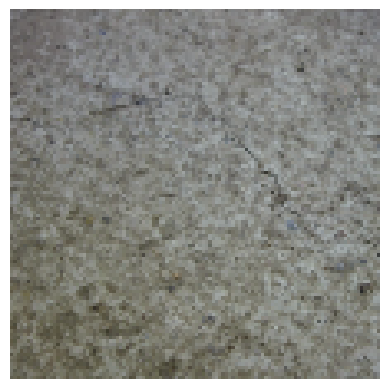

In [20]:
plt.imshow(X_val_1[515])
plt.axis('off')  # Hide axis
plt.show()

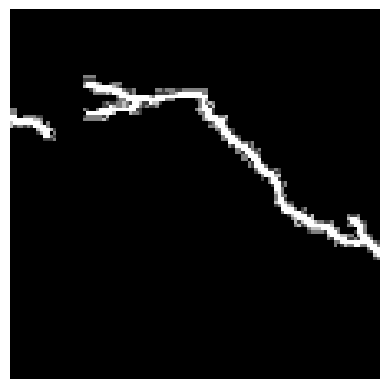

In [21]:
plt.imshow(y_val_1[515], cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

In [22]:
np.sum(y_val_1[15])

451.20392156862744

In [23]:
print(y_val_1[-1])

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [37]:


# Create data generators with desired augmentation parameters
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()  # No augmentation for validation data

unet_model_retrain = build_unet(input_shape)

for layer in unet_model_retrain.layers:
    if 'enoder' in layer.name:  # Only load weights for the encoder layers
        layer_name = "pre" + layer.name[-1]  # Assumes layer names are like "block1_conv"
        layer_weights = encoder.get_layer(layer_name).get_weights()
        layer.set_weights(layer_weights)
for layer in unet_model_retrain.layers[:4]:
    layer.trainable = False
    print(layer.name)

from tensorflow.keras.optimizers import Adam
optimizer1 = Adam(learning_rate=0.15) 
unet_model_retrain.compile(optimizer=optimizer1 ,
                #    loss=dice_loss,
                   loss = 'binary_crossentropy',
                   metrics=[metrics.Precision(),
                            metrics.Recall(),
                            metrics.FalsePositives(),
                            metrics.FalseNegatives(),
                            metrics.BinaryIoU(),
                            'accuracy'])

train_generator = train_datagen.flow(X_train_1, y_train_1, batch_size=16)
val_generator = val_datagen.flow(X_val_1, y_val_1, batch_size=1)

# unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model using the fit_generator function
history = unet_model_retrain.fit(
    train_generator, 
    steps_per_epoch=20,   
    epochs=10, 
    validation_data=val_generator,
    validation_steps=5   
)

input_layer_7
encoder1_conv
encoder1_bn
encoder1_pool
Epoch 1/10


c:\Users\link1\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7676 - binary_io_u_2: 0.4062 - false_negatives_2: 92248.5703 - false_positives_2: 314495.3750 - loss: 359970624.0000 - precision_2: 0.0569 - recall_2: 0.2218 - val_accuracy: 0.9496 - val_binary_io_u_2: 0.4937 - val_false_negatives_2: 3159.0000 - val_false_positives_2: 0.0000e+00 - val_loss: 0.1762 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9503 - binary_io_u_2: 0.4914 - false_negatives_2: 106379.1875 - false_positives_2: 267.4286 - loss: 4506934272.0000 - precision_2: 0.0102 - recall_2: 2.4991e-05 - val_accuracy: 0.9323 - val_binary_io_u_2: 0.4856 - val_false_negatives_2: 3463.0000 - val_false_positives_2: 773.0000 - val_loss: 12346294534144.0000 - val_precision_2: 0.0128 - val_recall_2: 0.0029
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6199 - binary_io_u_2: 0.3274 - false_negatives_2: 71100.4297 - false_positives_2: 834282.7500 - loss:

In [25]:

# Load and preprocess the image
image_path = 'CFD_001.jpg'
input_image = cv2.imread(image_path)
cv2.imwrite( "test_input.jpg", input_image)
input_image = cv2.resize(input_image, (112, 112))/255.0  # Resize to match your model's input shape
# image = image / 255.0  # Normalize the pixel values

input_image = np.expand_dims(input_image, axis=0) 
# Convert the image to a NumPy array with the expected shape
# input_image = np.expand_dims(image, axis=0)  # Add a batch dimension
input_image.shape

(1, 112, 112, 3)

In [26]:
unet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_conv       │ (None, 112, 112,  │      1,792 │ input_layer_5[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_bn         │ (None, 112, 112,  │        256 │ encoder1_conv[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_pool       │ (None, 56, 56,    │          0 │ encoder1_bn[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_conv       │ (None, 56, 56,    │     73,856 │ encoder1_pool[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_bn         │ (None, 56, 56,    │        512 │ encoder2_conv[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_pool       │ (None, 28, 28,    │          0 │ encoder2_bn[0][0] │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder3_conv       │ (None, 28, 28,    │    295,168 │ encoder2_pool[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder3_bn         │ (None, 28, 28,    │      1,024 │ encoder3_conv[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder3_pool       │ (None, 14, 14,    │          0 │ encoder3_bn[0][0] │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder4_conv       │ (None, 14, 14,    │  1,180,160 │ encoder3_pool[0]… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder4_bn         │ (None, 14, 14,    │      2,048 │ encoder4_conv[0]… │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder4_pool       │ (None, 7, 7, 512) │          0 │ encoder4_bn[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7,      │  4,719,616 │ encoder4_pool[0]… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 7,      │      4,096 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 7, 7,      │          0 │ batch_normalizat… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7,      │  9,438,208 │ re_lu[0][0]     

 Total params: 89,501,637 (341.42 MB)

 Trainable params: 29,829,953 (113.79 MB)

 Non-trainable params: 11,776 (46.00 KB)

 Optimizer params: 59,659,908 (227.58 MB)

In [27]:
prediction = unet_model_retrain.predict([input_image])
prediction.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


(1, 112, 112, 1)

In [34]:
prediction_baseline = unet_model.predict([input_image])
prediction_baseline.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


(1, 112, 112, 1)

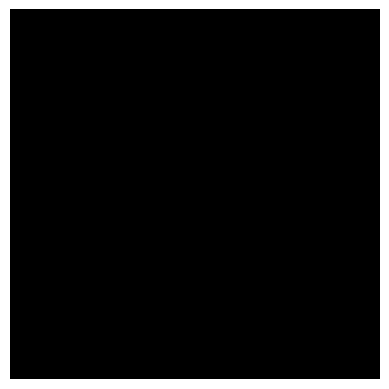

In [39]:
prediction_image_baseline = prediction_baseline[0]

# Now, display the image
plt.imshow(prediction_image_baseline, cmap='gray')  # Use an appropriate colormap if not binary
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

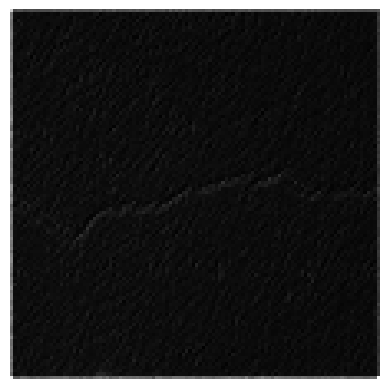

In [41]:
prediction_image = prediction[0]

# Now, display the image
plt.imshow(prediction_image, cmap='gray')  # Use an appropriate colormap if not binary
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
 